In [1]:
import os
os.chdir('..')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from collections import defaultdict
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15.0, 7.0)
sns.set(style="ticks")

In [2]:
import matplotlib
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (15.0, 7.0)

In [3]:
%load_ext autoreload

In [4]:
from com.loan import Loan
from com.investor import Investor
from com.backtest import Backtest
from com.tester import Tester

In [5]:
from com.lc_helpers import (get_cache_historic)

In [6]:
input_db = get_cache_historic()

In [7]:
dates = sorted(input_db['issue_d'].unique())
dates[0], dates[-1]

(Period('2007-06', 'M'), Period('2015-12', 'M'))

In [8]:
from com.backtest import generic_buy_solver, simple_filter_buy_solver

In [57]:
%autoreload Backtest
model_db = input_db[input_db['grade'].isin(['C', 'D', 'E', 'F'])]
bt = Backtest(dates[12], dates[-1], simple_filter_buy_solver, model_db, cash=1000, liquidity_limit=0.25)

In [58]:
#tester = Tester(dates[12], dates[-1], simple_filter_buy_solver, model_db, cash=1000, liquidity_limit=0.3, backtest_number=5)

In [59]:
result = bt.run()

2008-06 2015-12
available 30
matching 5
solver number 40.0
solver number restricted 1
2008-07 2015-12
available 41
matching 4
solver number 39.0
solver number restricted 1
2008-08 2015-12
available 41
matching 2
solver number 38.0
solver number restricted 0
2008-09 2015-12
available 18
matching 0
solver number 38.0
solver number restricted 0
2008-10 2015-12
available 48
matching 11
solver number 38.0
solver number restricted 2
2008-11 2015-12
available 82
matching 11
solver number 36.0
solver number restricted 2
2008-12 2015-12
available 104
matching 15
solver number 34.0
solver number restricted 3
2009-01 2015-12
available 116
matching 9
solver number 32.0
solver number restricted 2
2009-02 2015-12
available 162
matching 14
solver number 30.0
solver number restricted 3
2009-03 2015-12
available 176
matching 12
solver number 28.0
solver number restricted 3
2009-04 2015-12
available 160
matching 10
solver number 25.0
solver number restricted 2
2009-05 2015-12
available 138
matching 16
s

In [60]:
from jinja2 import Template, Environment, PackageLoader
from collections import OrderedDict


class Report():

    def __init__(self, backtest, filepath=None):
        self.backtest = backtest
        self.filepath = filepath

    def save(self, filepath=None):
        if not filepath:
            filepath = self.filepath

        bt = self.backtest
        
        summary_dict = OrderedDict()
        summary_dict['Title'] = 'Lending Club Report'
        summary_dict['Date'] = str(datetime.datetime.now()).split('.')[0]
        summary_dict['Solver Function'] = bt.buy_solver_name
        summary_dict['Annualized Return'] = np.round((1.0 + bt.stats['monthly return']['20120101':].mean()) ** 12, 3)
        summary_dict['Annualized Volatity'] = np.round(bt.stats['monthly return'].std() * np.sqrt(12), 3)
        summary_dict['Mean Return'] = np.round(bt.stats['monthly return'].mean(), 3)
        summary_dict['Standard Deviation'] = np.round(bt.stats['monthly return'].std(), 3)
        summary_dict['Skew'] = np.round(bt.stats['monthly return'].skew(), 3)
        summary_dict['Kurtosis'] = np.round(bt.stats['monthly return'].kurt(), 3)
        summary_dict['Sharpe'] = np.round(bt.stats_dict['sharpe'], 3)
        summary_dict['Transaction Fee'] = 0.01
        
        summary_df = pd.Series(summary_dict)
        
        net_worth = bt.stats['net worth'].plot(title='Net Worth', figsize=(18,8))
        net_worth.get_figure().savefig('net_worth.png')
        plt.close()    
        
        monthly_return = bt.stats['monthly return'].plot(title='Monthly Returns', figsize=(6,8))
        monthly_return.get_figure().savefig('monthly_return.png')
        plt.close()
        
        mean_duration = bt.loan_stats['duration'].mean(axis=1).plot(title='Mean Portfolio Remaning Lifetime', figsize=(6,8))
        mean_duration.get_figure().savefig('mean_duration.png')
        plt.close()
        
        default_rate = bt.stats['default rate'].plot(title='Default Rate', figsize=(6,8))
        default_rate.get_figure().savefig('default_rate.png')
        plt.close()

        growth_of_one = bt.stats['growth of $1'].plot(title='Growth of $1', )
        growth_of_one.get_figure().savefig('growth_of_one.png')
        plt.close()
        
        int_rate_breakdown = bt.loan_stats_total['int_rate'].plot.hist(title='Distribution of Interest Rates', figsize=(6,8))
        int_rate_breakdown.get_figure().savefig('int_rate_breakdown.png')
        plt.close()

        grade_breakdown = (bt.loan_stats_total['grade'] / bt.loan_stats_total['grade'].sum()).plot.bar(title='Distribution of Grades', figsize=(6,8), colors='rgbymc')
        grade_breakdown.get_figure().savefig('grade_breakdown.png')
        plt.close()
        
        imbalance_percentage = bt.loan_stats_total['imbalance_percentage'][bt.loan_stats_total['imbalance_percentage'].abs() <= 0.1].plot.hist(figsize=(6,8), title='Distribution of Loan Imbalance', bins=30)
        imbalance_percentage.get_figure().savefig('imbalance_percentage.png')
        plt.close()
        
        available_loans = bt.stats['available loans'].plot(title='Available Loans', figsize=(6, 8))
        available_loans.get_figure().savefig('available_loans.png')
        plt.close()  
        
        
        loans_held = bt.stats['loans held'].plot(label='Loans Held', title='Loans Held', figsize=(6,8))
        bt.stats['loans added'].plot(label='Loans Added', title='Loans Added', figsize=(6, 8))
        plt.legend()
        loans_held.get_figure().savefig('loans_held.png')
        plt.close()
        
        cash_held = bt.stats['cash held'].plot(title='Cash Held', figsize=(6,8))
        cash_held.get_figure().savefig('cash_held.png')
        plt.close()
        
        liquidity = bt.stats['total liquidity'].plot(title='Liquidity (% Market Cap)', label='Total Liquidity', figsize=(6, 8))
        bt.stats['strategy liquidity'].plot(label='Strategy Liquidity', figsize=(6, 8))
        plt.legend()
        liquidity.get_figure().savefig('liquidity.png')
        plt.close()
        
        
        grade_monthly = (bt.loan_stats['grade']).plot(title='Monthly Breakdown by Grade', figsize=(10,8))
        grade_monthly.get_figure().savefig('grade_monthly.png')
        plt.close()
        
        grade_int_monthly = bt.loan_stats['grade_int_rate'].plot(title='Monthly Interest Rate by Grade', figsize=(10,8))
        grade_int_monthly.get_figure().savefig('grade_int_monthly.png')
        plt.close()
            
        env = Environment(loader=PackageLoader('reports', 'templates'))
        template = env.get_template('template.html')
        css = env.get_template('report.css')
        
        output = template.render(
            css=css.render(),
            summary = pd.DataFrame(summary_df).to_html()
        )
        
        with open(filepath, 'w') as fp:
            fp.write(output)
        return output

In [61]:
Report(bt, 'test1.html').save()
print ''

In [14]:
# model_db.columns[model_db.columns.str.contains('purpose')]

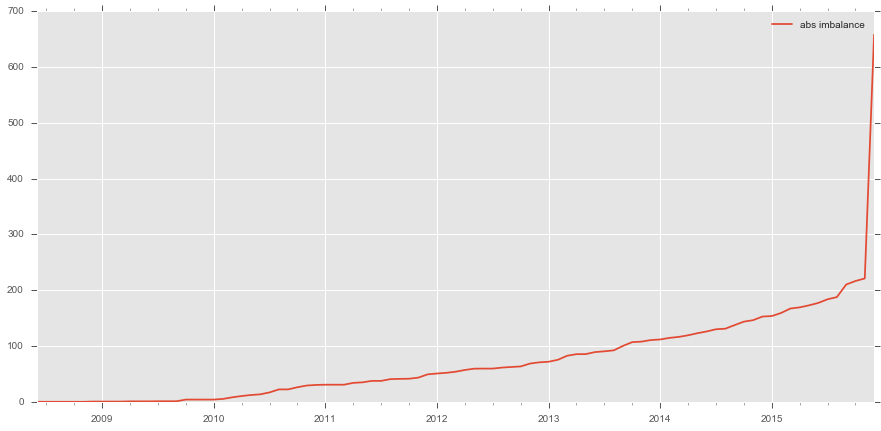

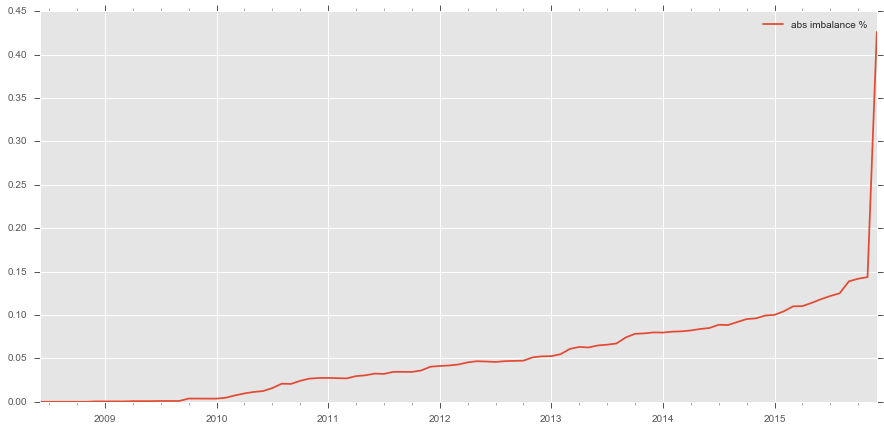

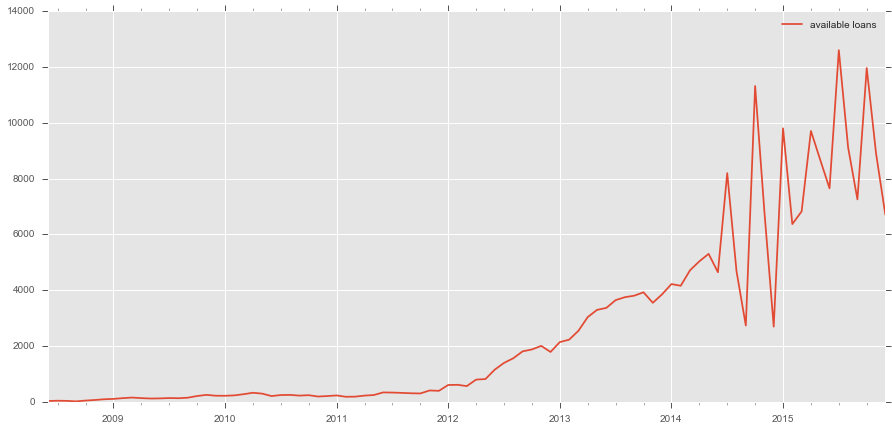

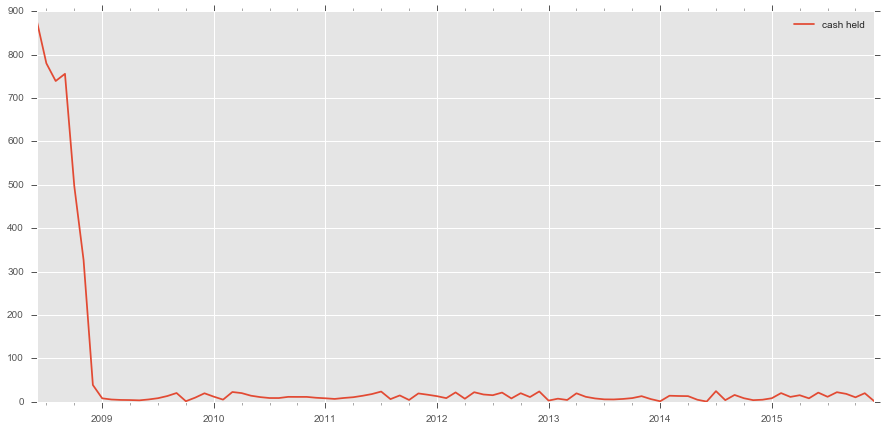

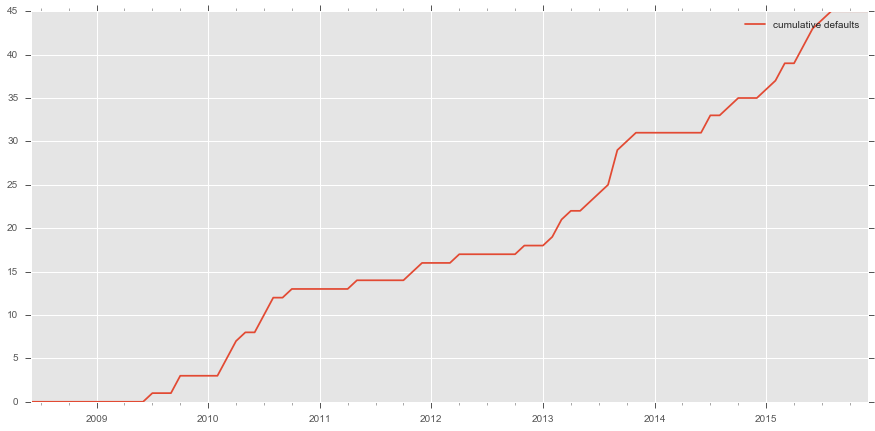

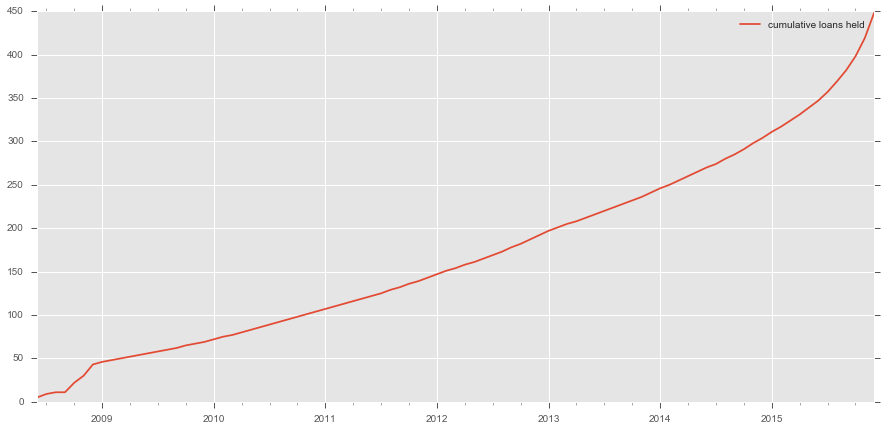

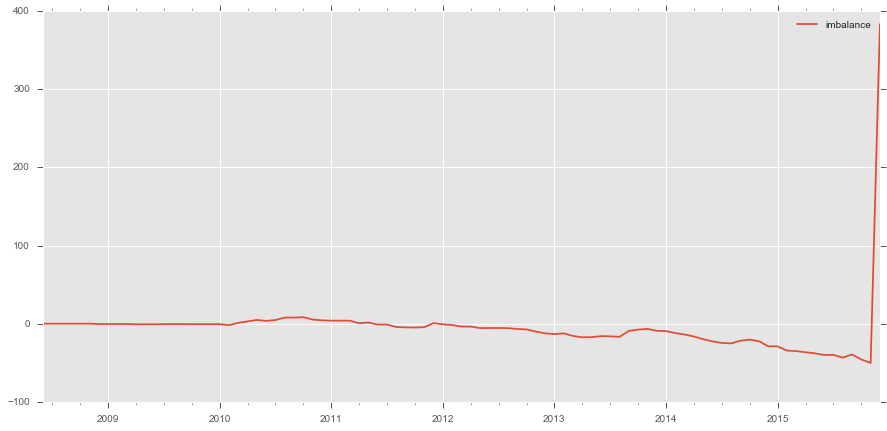

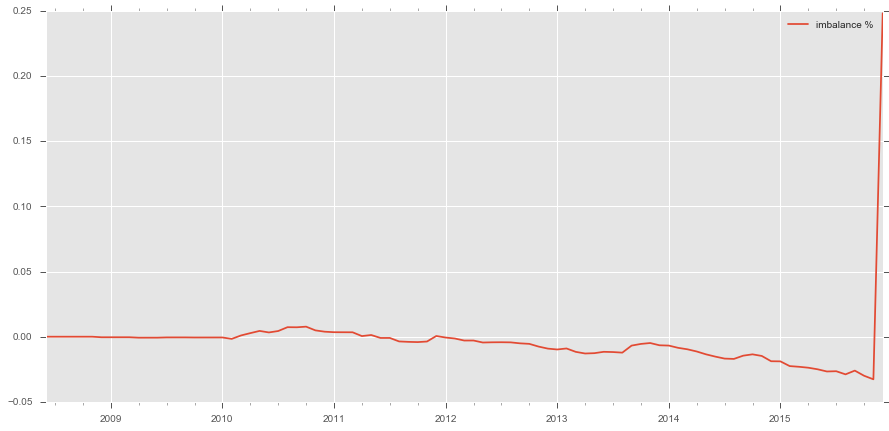

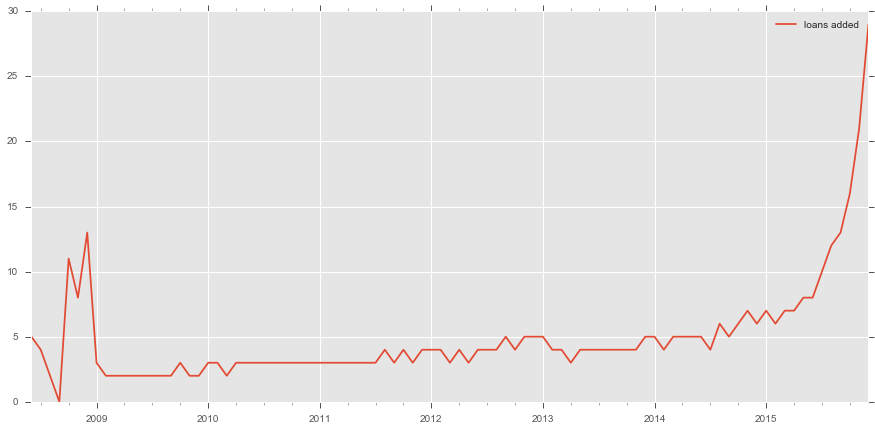

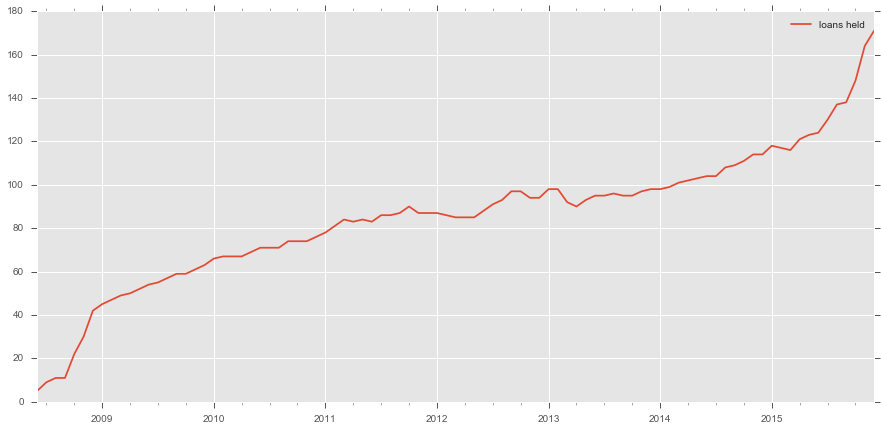

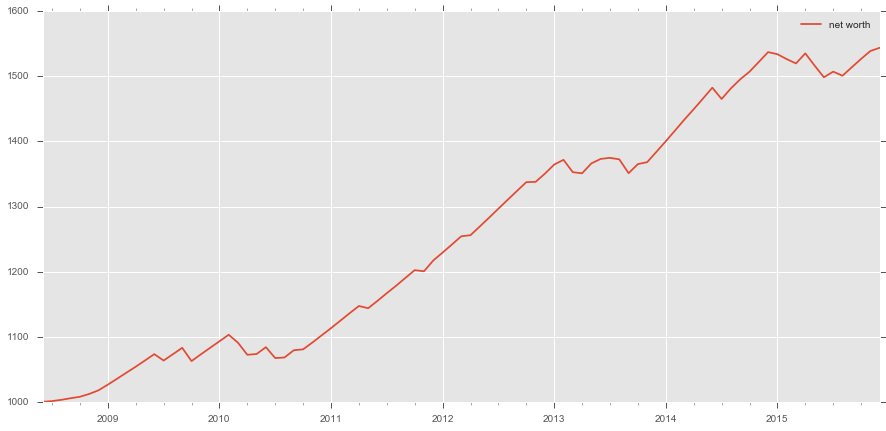

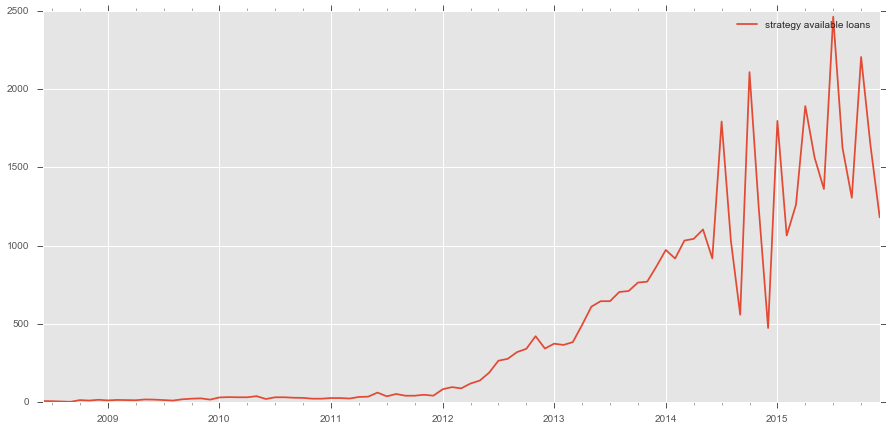

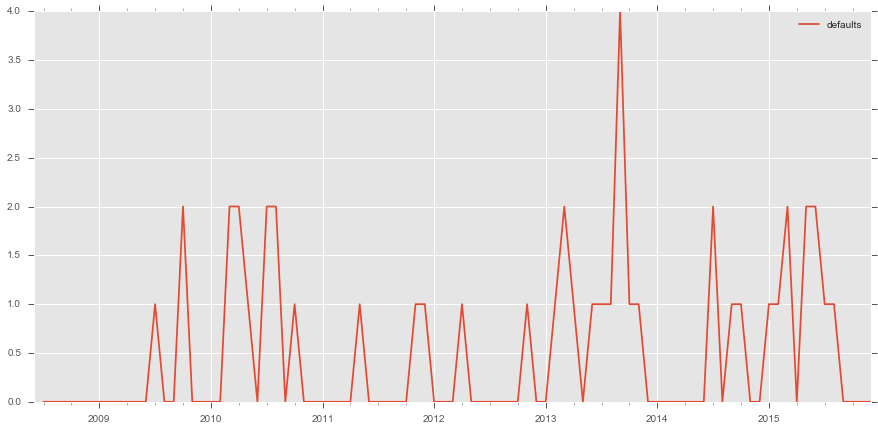

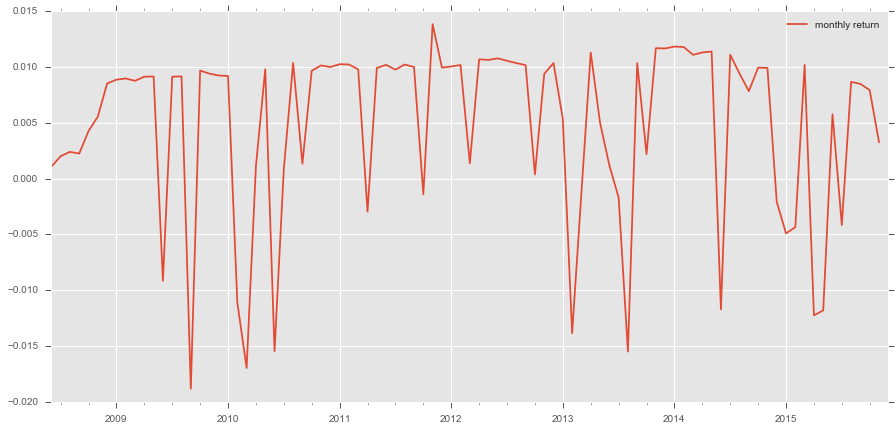

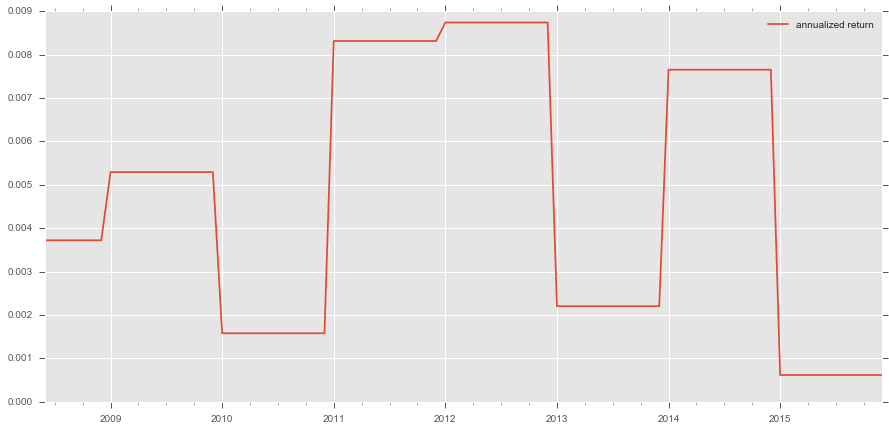

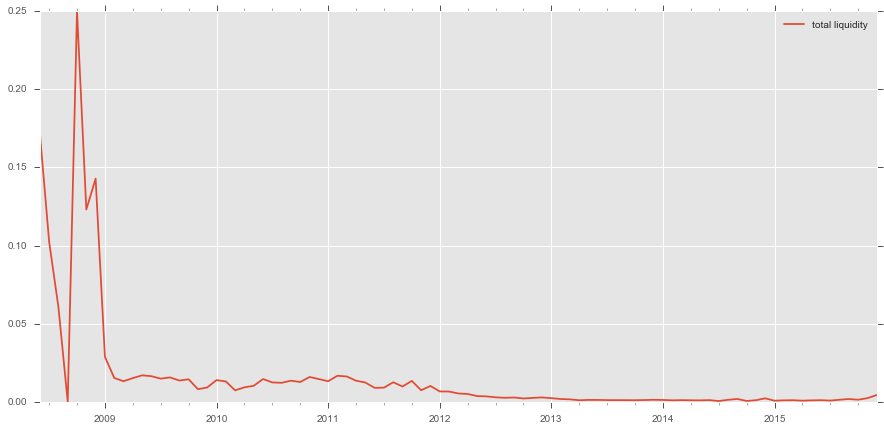

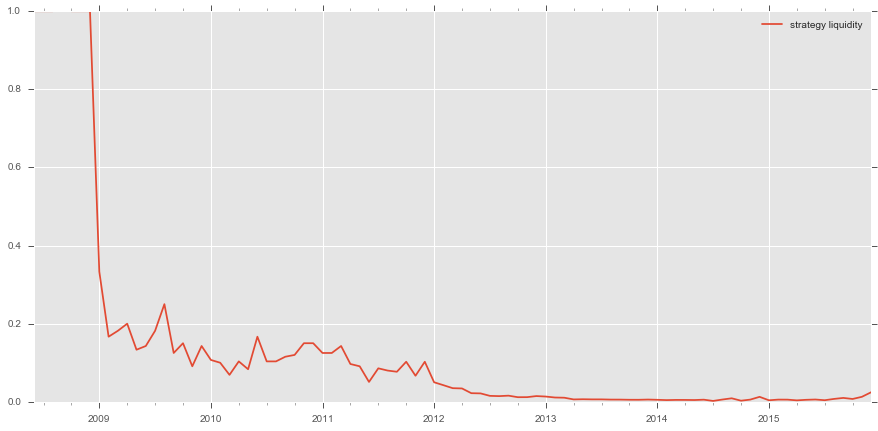

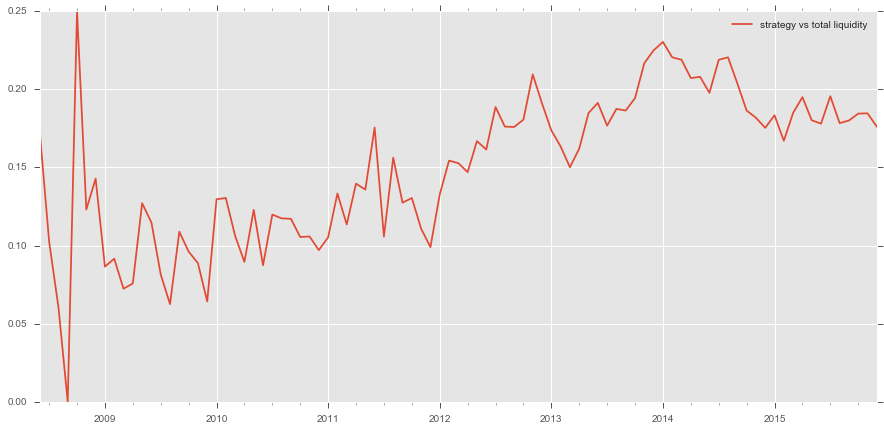

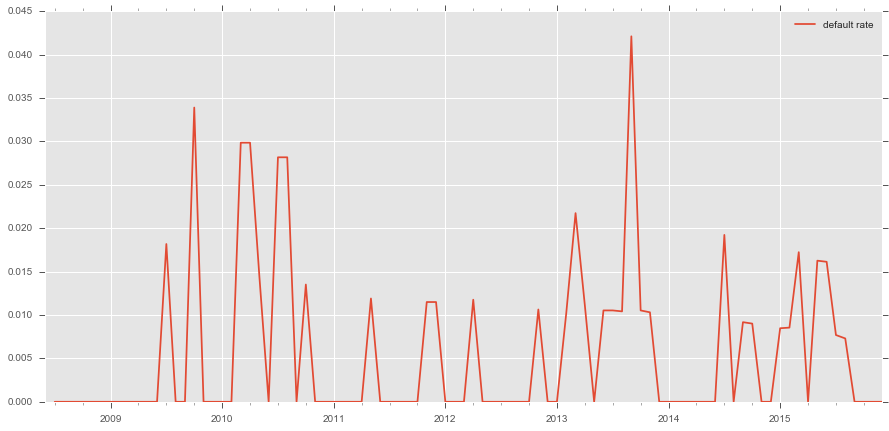

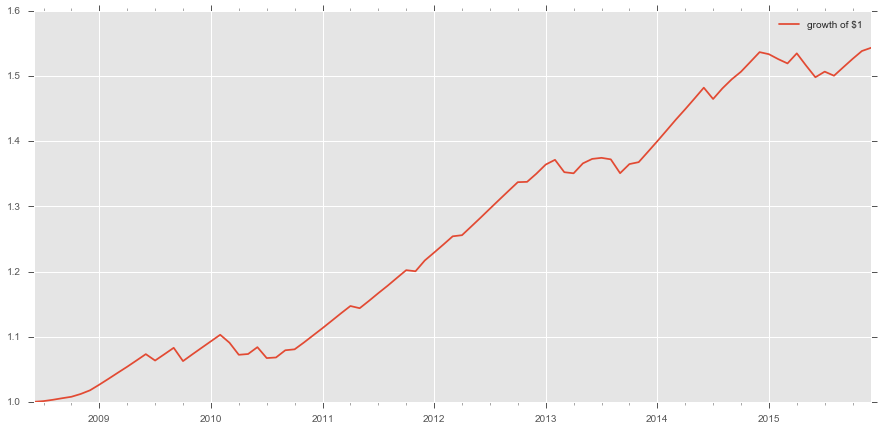

In [15]:
for column in bt.stats.columns:
    bt.stats[column].plot(label=column)
    plt.legend()
    plt.show()

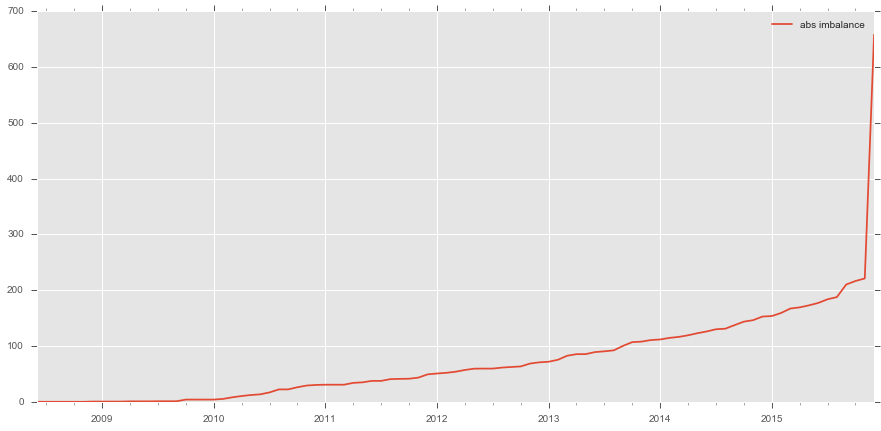

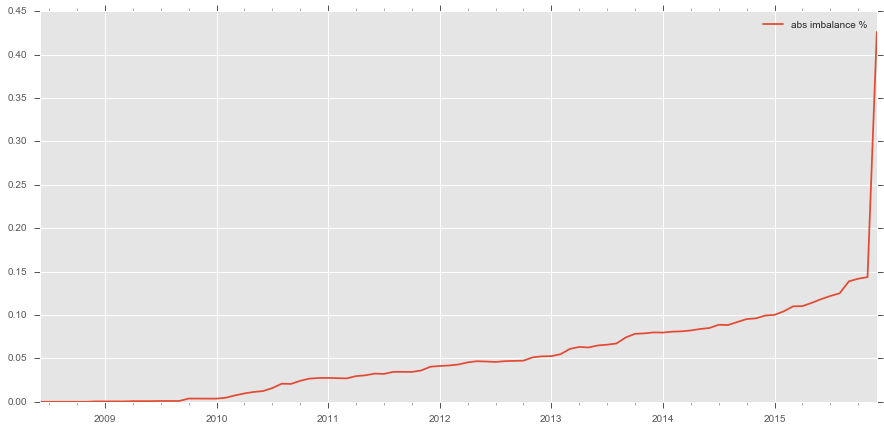

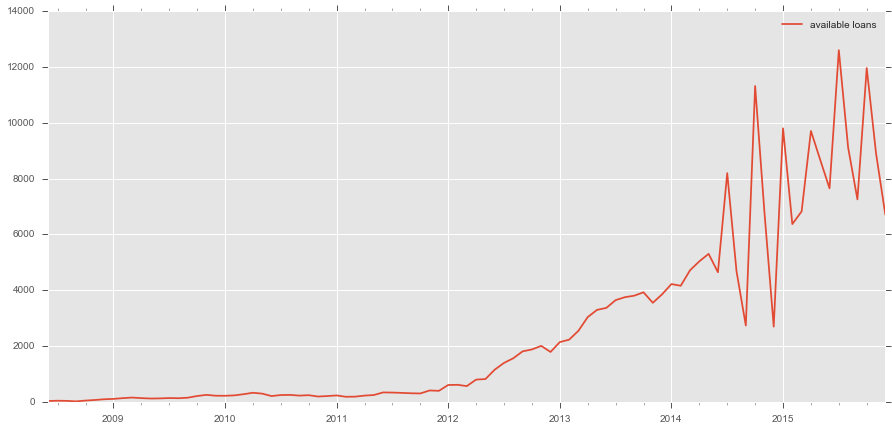

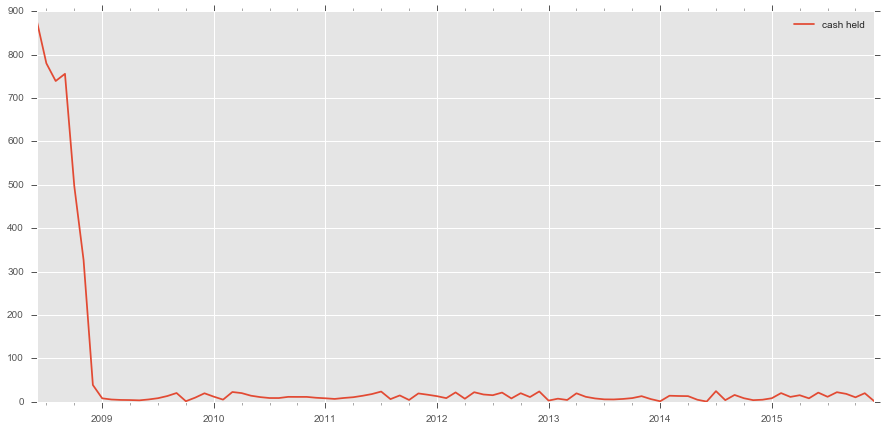

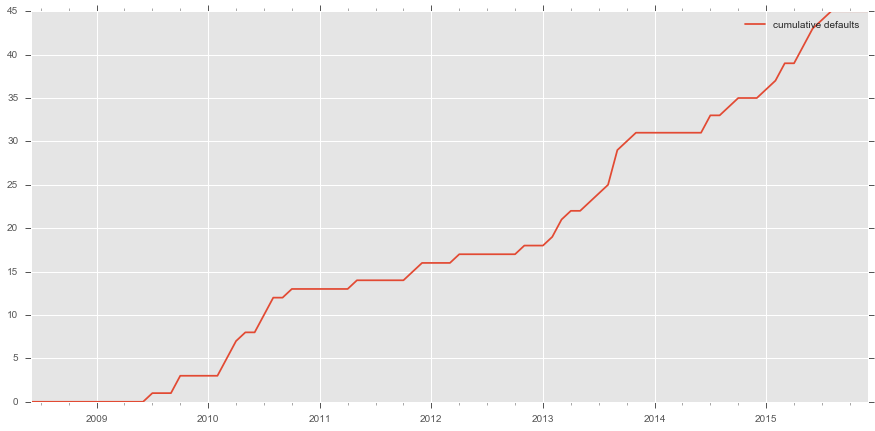

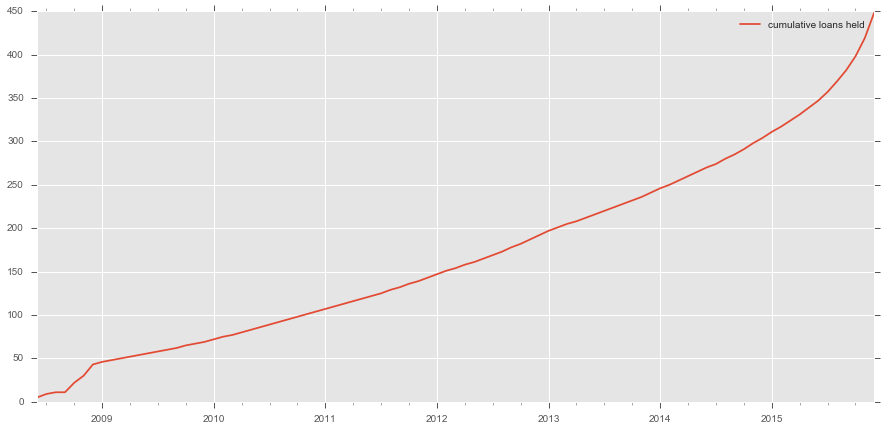

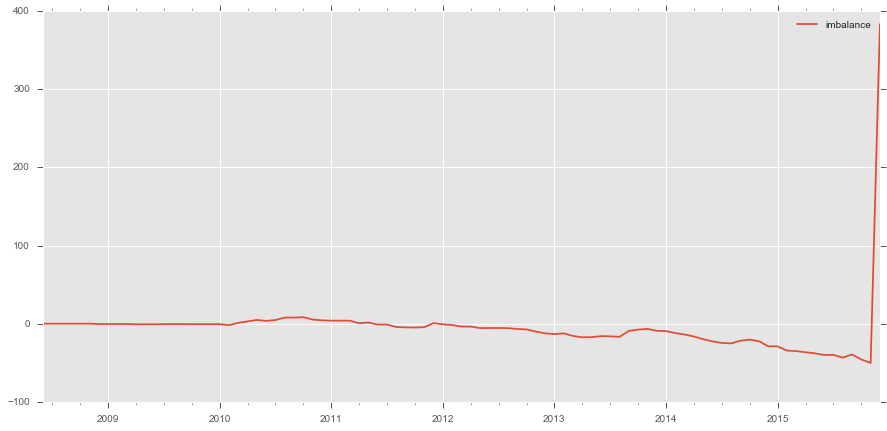

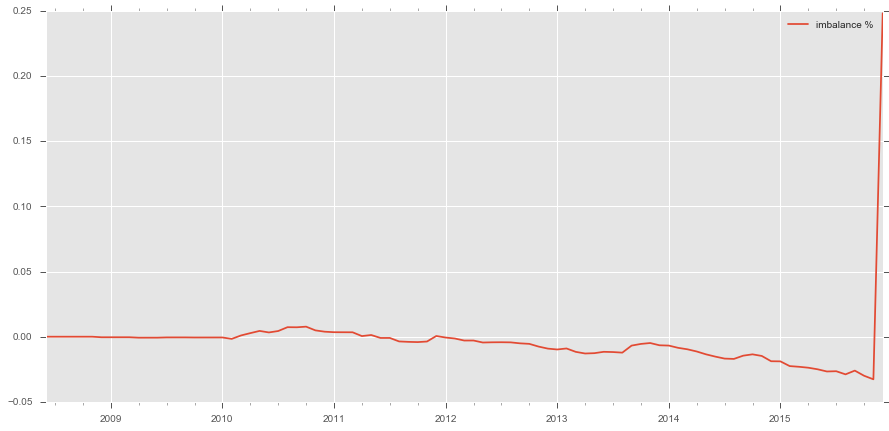

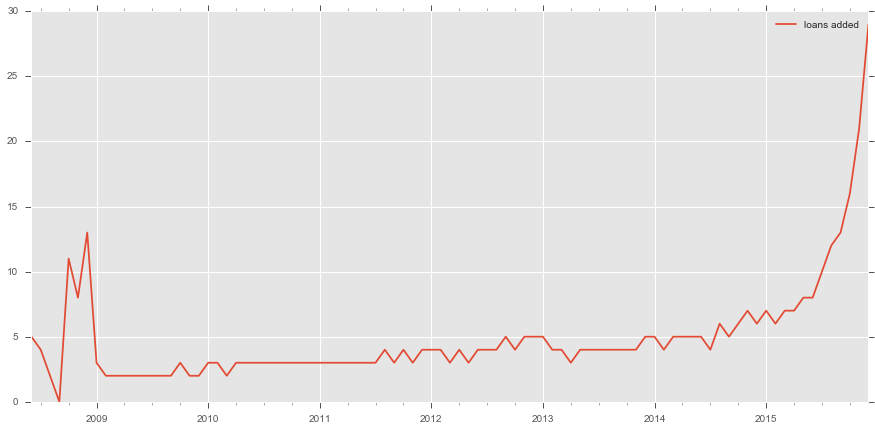

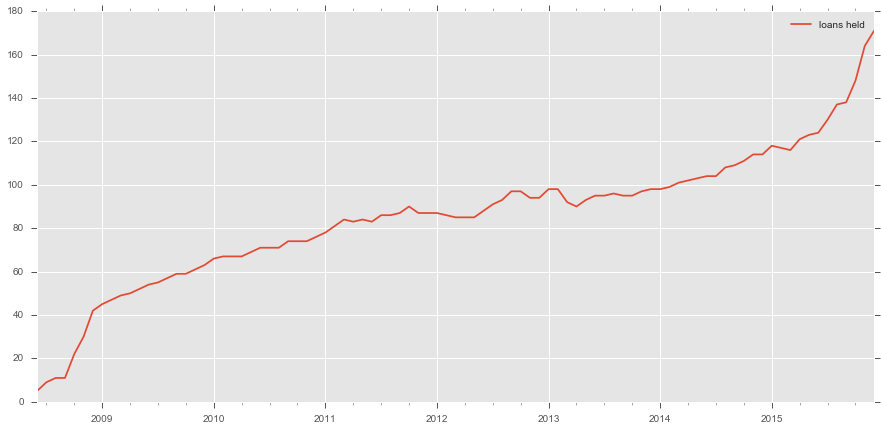

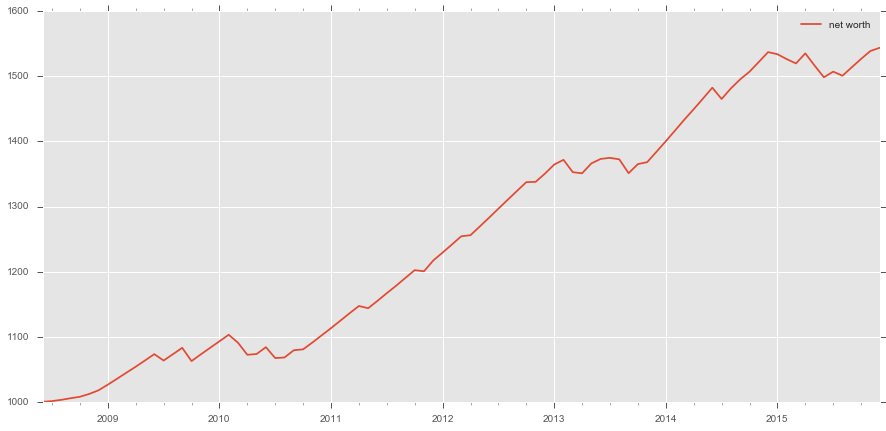

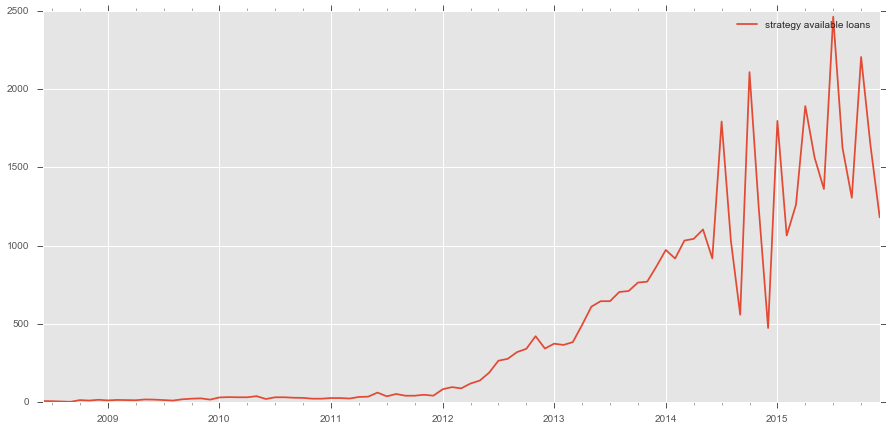

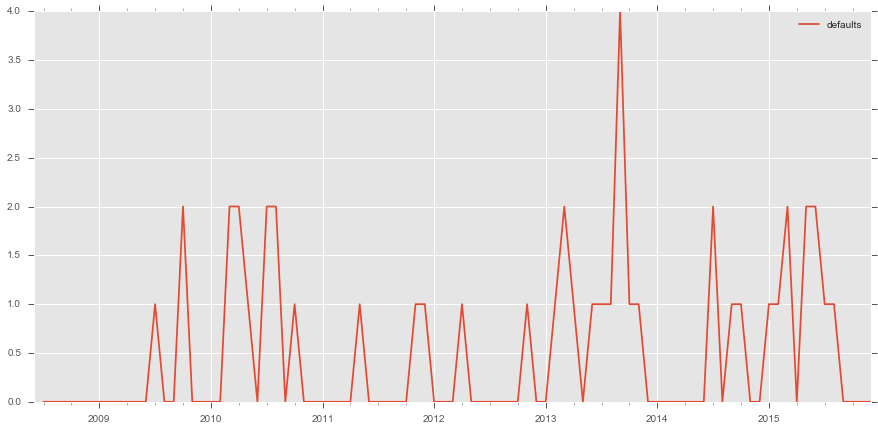

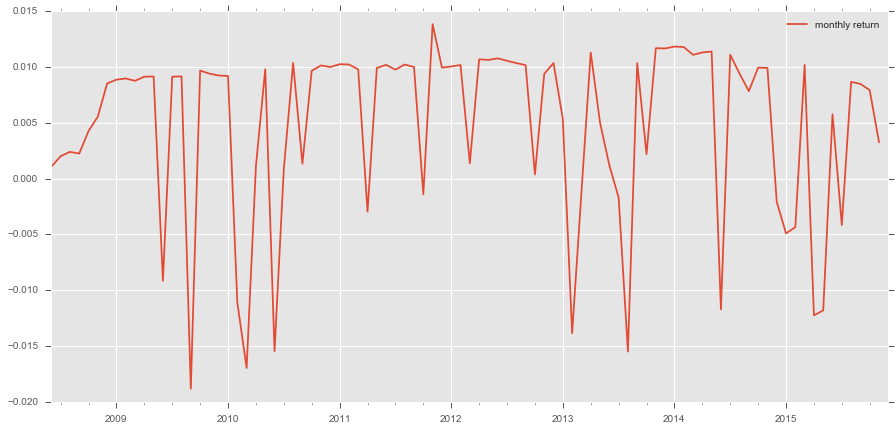

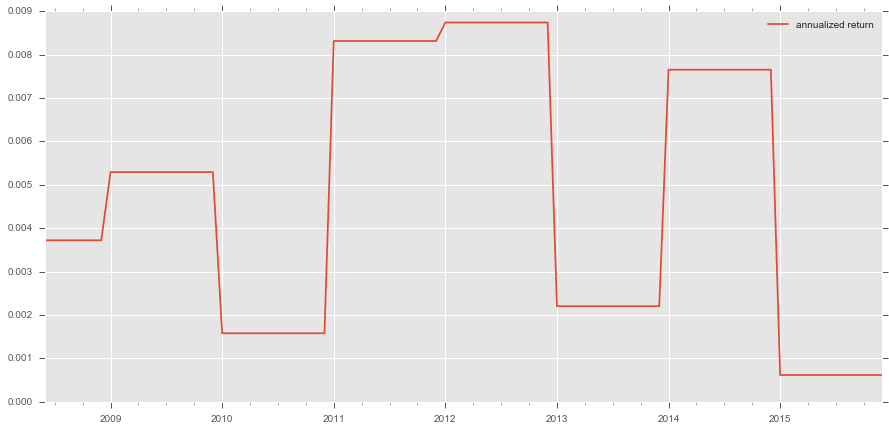

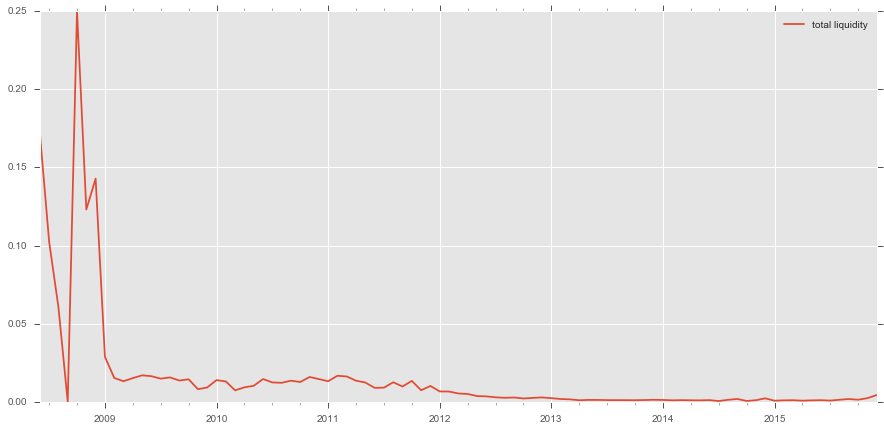

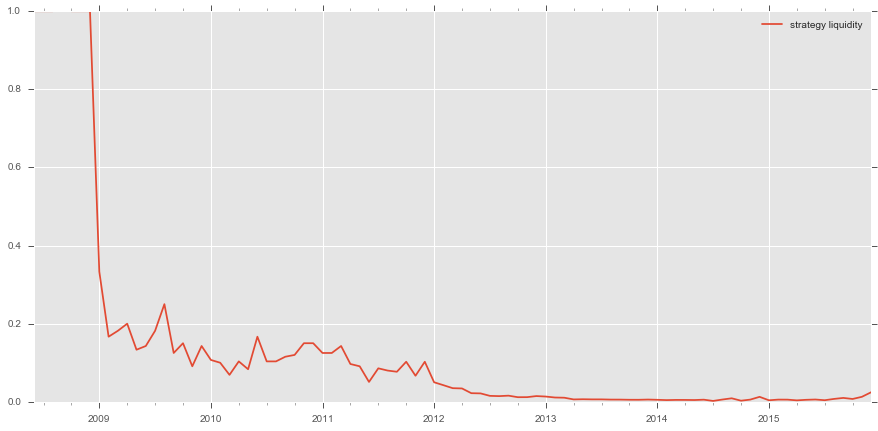

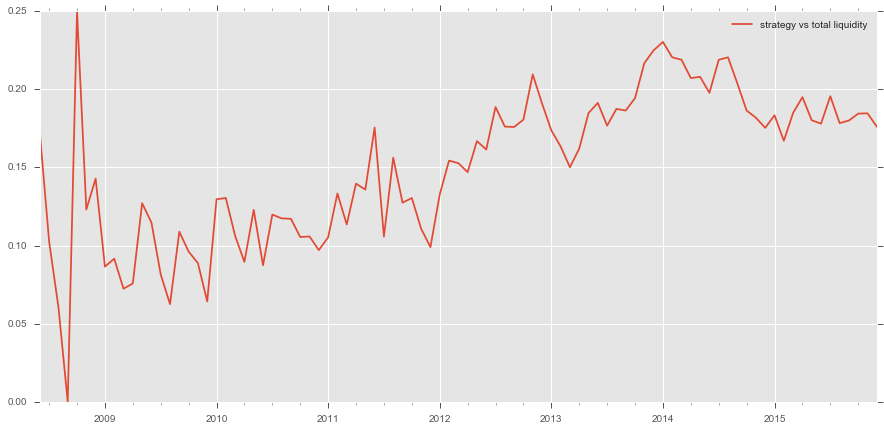

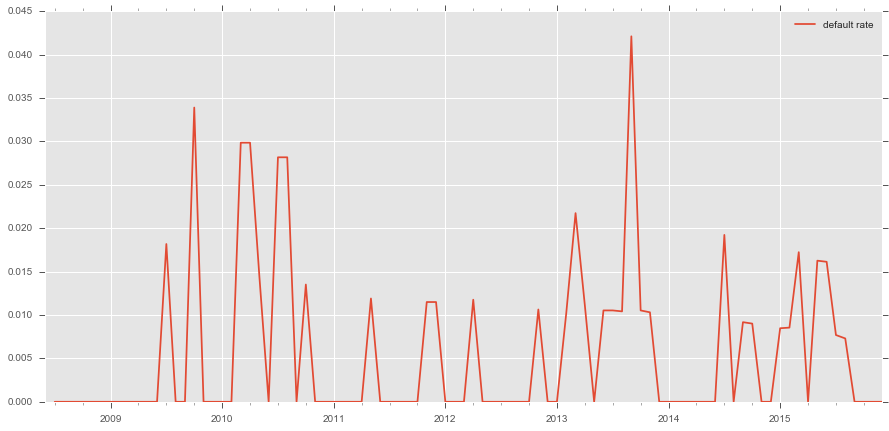

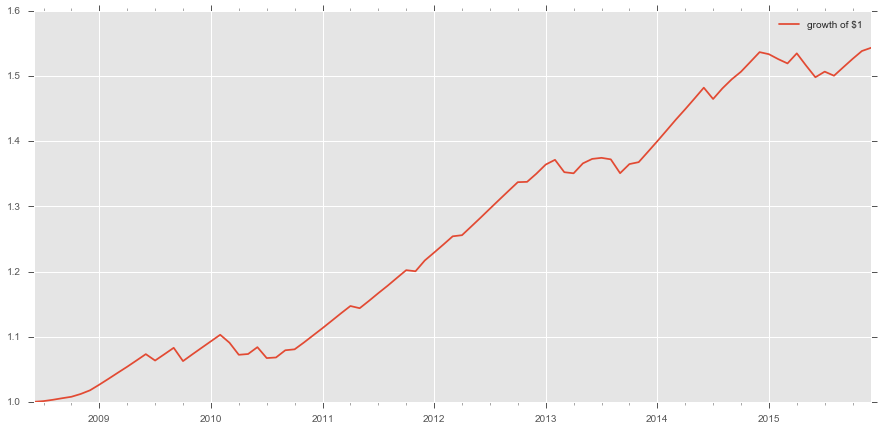

In [16]:
for column in bt.stats.columns:
    bt.stats[column].plot(label=column)
    plt.legend()
    plt.show()

In [43]:
df = input_db
x = simple_filter_buy_solver('', '', df, df.shape[0], 1.0)['loans'].groupby(['issue_d', 'grade'])['defaulted']
default_by_grade = (x.value_counts().unstack().unstack()[1] / x.count().unstack())

available 606421
matching 133564
solver number 606421
solver number restricted 133564


In [44]:
x1 = default_by_grade

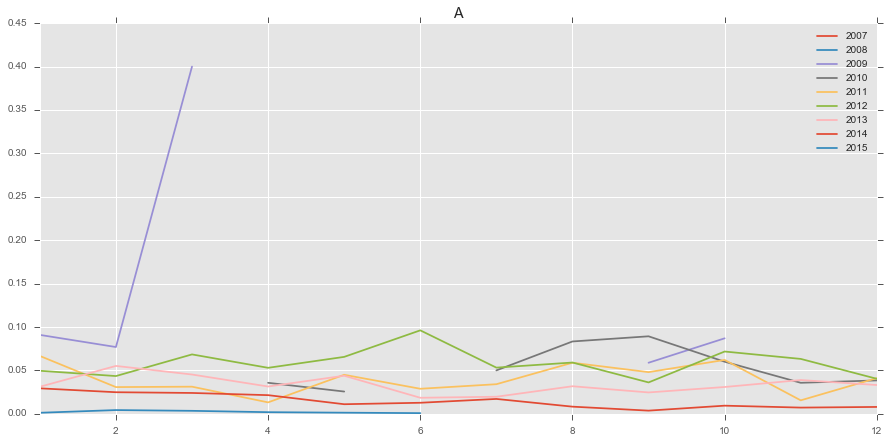

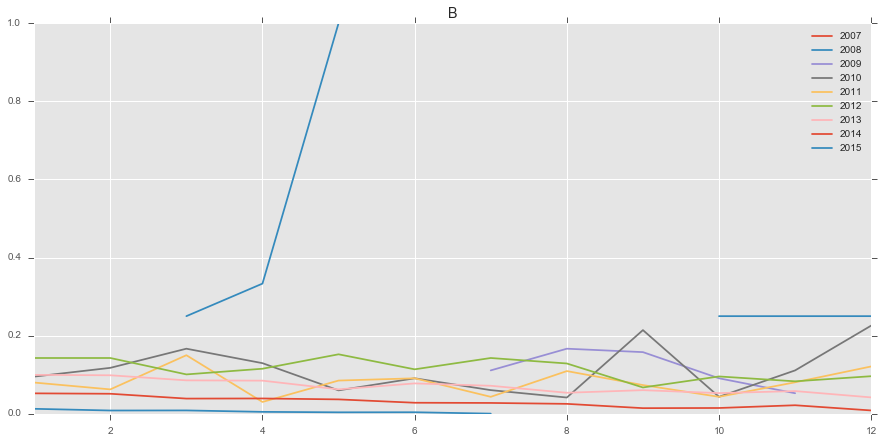

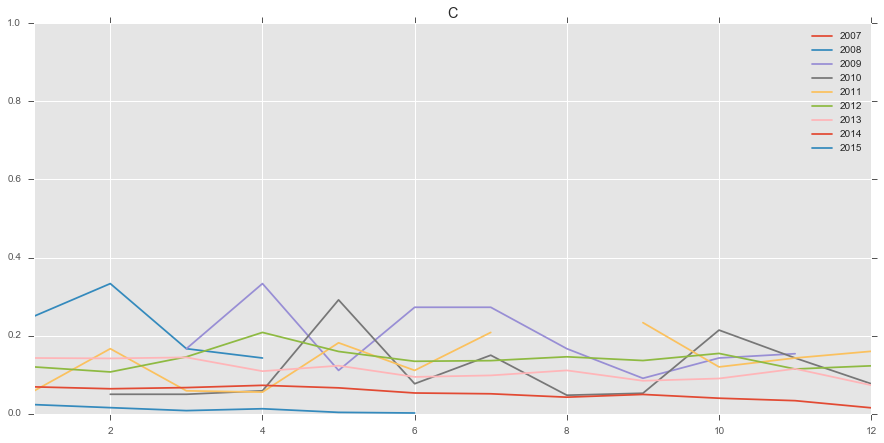

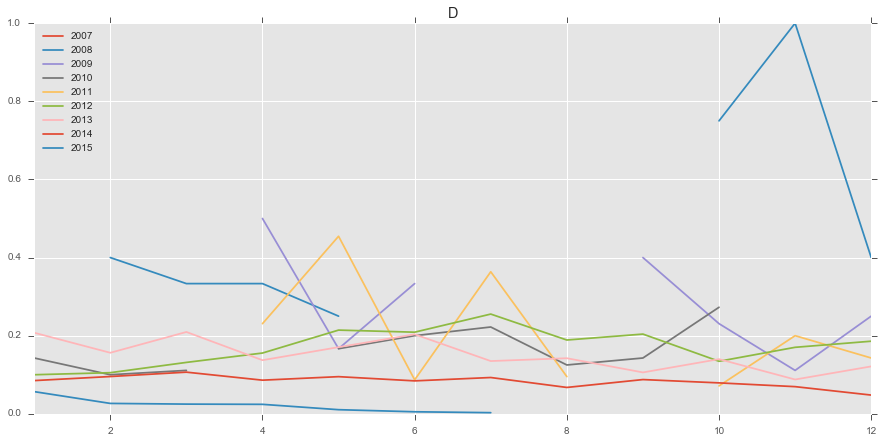

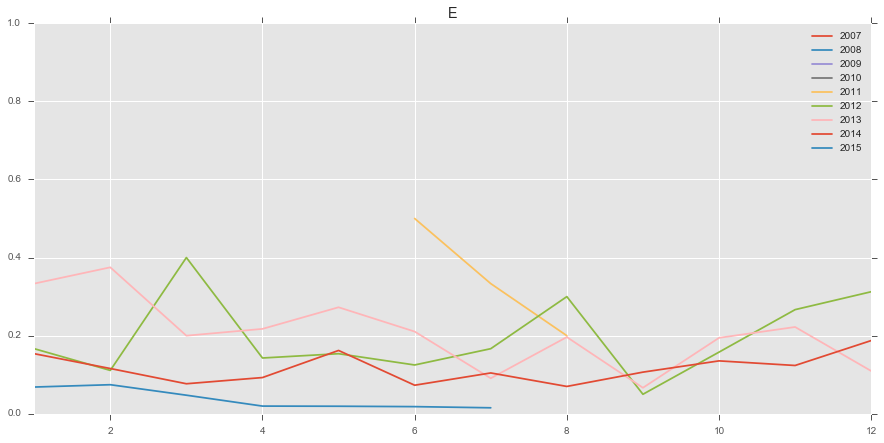

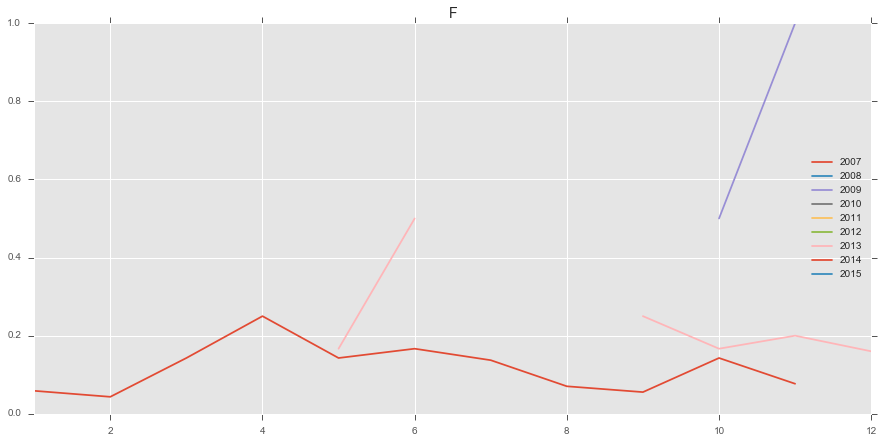

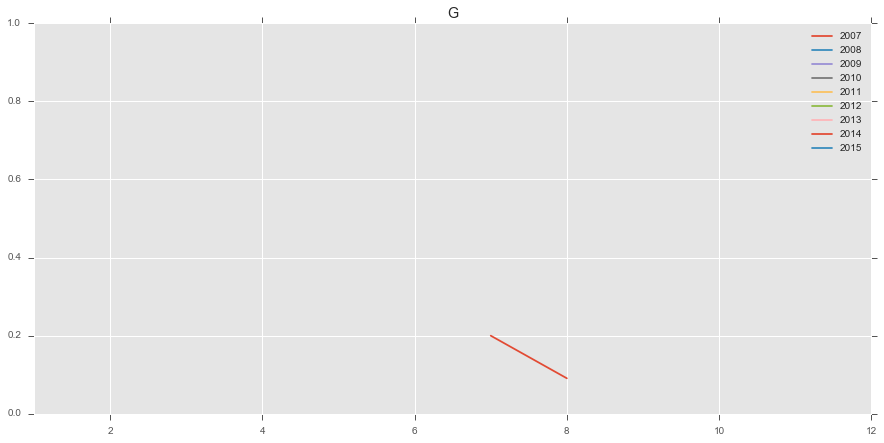

In [45]:
for grade in x1.columns:
    x1.groupby([x1.index.month, x1.index.year]).mean().unstack()[grade].plot(title=grade)
    #x1[grade].plot(title=grade)
    plt.show()

TypeError: Could not operate <matplotlib.axes._subplots.AxesSubplot object at 0x15cbe4810> with block values unsupported operand type(s) for /: 'float' and 'AxesSubplot'

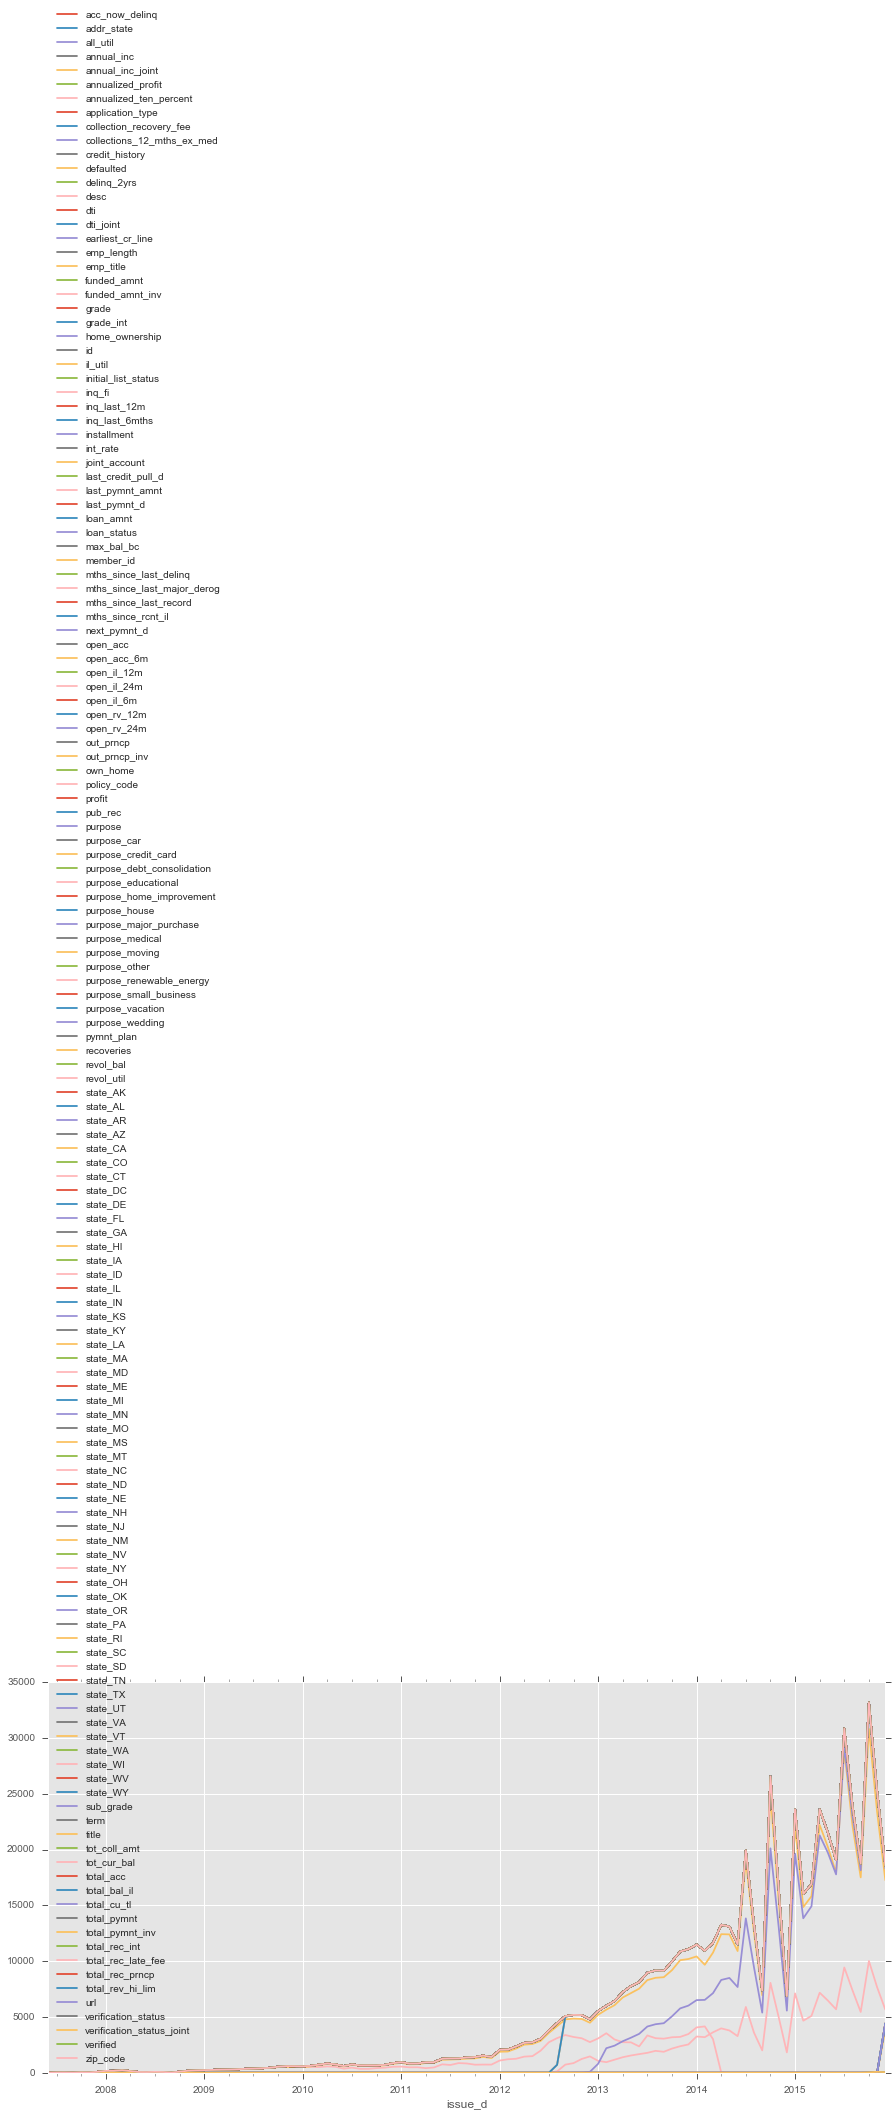

In [46]:
df.groupby('issue_d')['grade'].value_counts().unstack() / df.groupby('issue_d').count().plot()

In [ ]:
defaults = df.query('loan_status == "Default"')
(defaults['last_pymnt_d'] - defaults['issue_d']).plot.hist(bins=30)